In [50]:
import polars as pl
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN 
%matplotlib inline

In [45]:
with open("data/animals.json", "r") as data_file:
        data = json.load(data_file)

df = pl.DataFrame(data)

In [5]:
df.head(5)

walks_on_n_legs,height,weight,has_wings,has_tail
i64,f64,f64,bool,bool
2,1.89662,52.244593,false,true
2,1.87068,84.608978,false,true
4,0.151612,7.855076,false,true
2,1.824498,75.800981,false,true
4,0.2799,46.757356,false,true


In [14]:
df.describe()

statistic,walks_on_n_legs,height,weight,has_wings,has_tail
str,f64,f64,f64,f64,f64
"""count""",1000.0,1000.0,1000.0,1000.0,1000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",2.995,1.492775,1146.052381,0.258,0.985
"""std""",1.024707,1.337228,2046.772823,null,null
"""min""",1.0,0.136315,0.075579,0.0,0.0
"""25%""",2.0,0.384633,6.241849,null,null
"""50%""",3.0,1.617079,57.774582,null,null
"""75%""",4.0,2.513869,727.215039,null,null
"""max""",5.0,9.83936,6897.044478,1.0,1.0


# Dummify boolean columns

In [29]:
df = df.to_dummies(['has_wings', 'has_tail'])
df = df.drop(["has_wings_false", "has_tail_false"])

In [47]:
df = df.with_columns([
    pl.col(col).cast(pl.Int8) for col in df.columns if df.schema[col] == pl.Boolean
])

In [49]:
df.head(5)

walks_on_n_legs,height,weight,has_wings,has_tail
i64,f64,f64,i8,i8
2,1.89662,52.244593,0,1
2,1.87068,84.608978,0,1
4,0.151612,7.855076,0,1
2,1.824498,75.800981,0,1
4,0.2799,46.757356,0,1


# Plotting

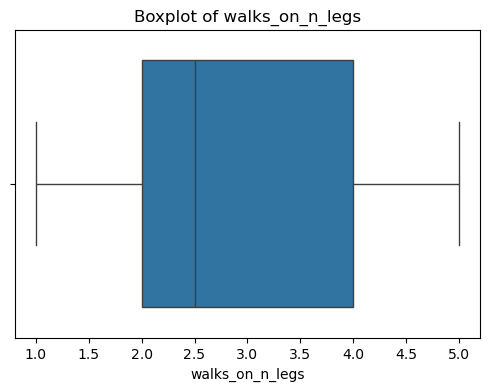

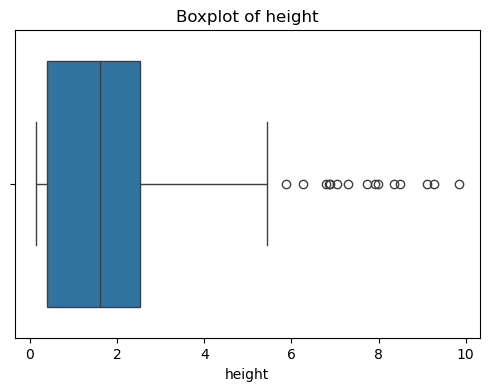

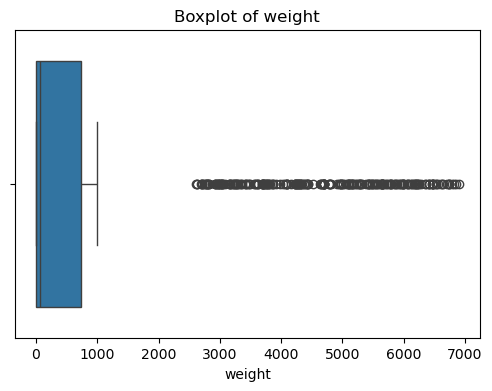

In [31]:
for column in ['walks_on_n_legs', 'height', 'weight']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

In [43]:
def remove_outliers_iqr(df: pl.DataFrame, column: str) -> pl.DataFrame:
    
    q1 = df.select(pl.col(column).quantile(0.25, "nearest")).item()
    q3 = df.select(pl.col(column).quantile(0.75, "nearest")).item()
    
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    return df.filter((pl.col(column) >= lower) & (pl.col(column) <= upper))

In [41]:
clean_df = df.clone()
for col in ['walks_on_n_legs', 'height', 'weight']:
    clean_df = remove_outliers_iqr(clean_df, col)

In [42]:
clean_df.describe()

statistic,walks_on_n_legs,height,weight,has_wings_true,has_tail_true
str,f64,f64,f64,f64,f64
"""count""",747.0,747.0,747.0,747.0,747.0
"""null_count""",0.0,0.0,0.0,0.0,0.0
"""mean""",2.674699,0.912058,45.55323,0.331995,0.990629
"""std""",0.970028,0.751317,75.976438,0.471245,0.096413
"""min""",1.0,0.136315,0.075579,0.0,0.0
"""25%""",2.0,0.331891,3.145788,0.0,1.0
"""50%""",2.0,0.503814,44.04709,0.0,1.0
"""75%""",4.0,1.714025,65.353391,1.0,1.0
"""max""",5.0,4.619763,839.574007,1.0,1.0


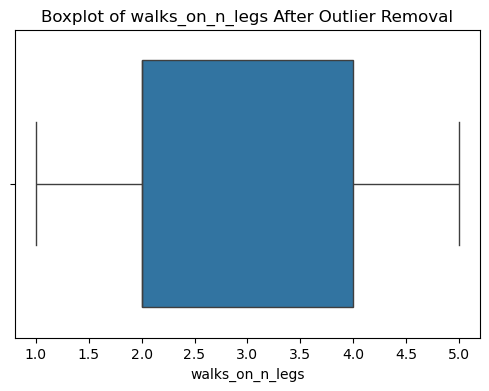

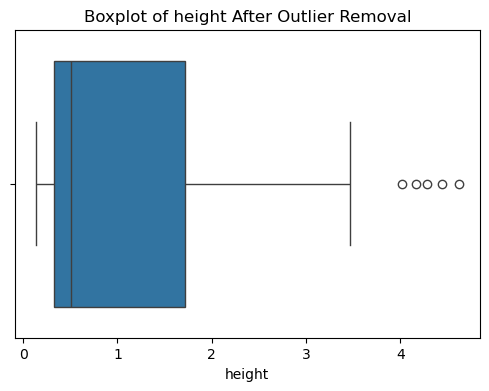

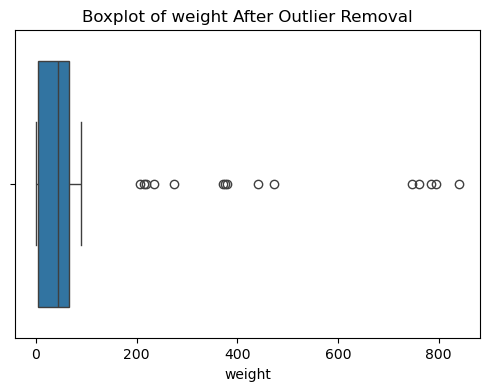

In [44]:
for column in ['walks_on_n_legs','height', 'weight']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=clean_df[column])
    plt.title(f'Boxplot of {column} After Outlier Removal')
    plt.show()

# Clustering to label data

In [61]:
# Seleccionar columnas para clustering
features = df.select(["walks_on_n_legs", "height", "weight"]).to_numpy()

# Normalizar si es necesario (DBSCAN es sensible a la escala)
from sklearn.preprocessing import StandardScaler
features_scaled = StandardScaler().fit_transform(features)

# Aplicar DBSCAN
db = DBSCAN(eps=0.2, min_samples=10)
labels = db.fit_predict(features_scaled)

# Añadir resultados al DataFrame
dff = df.with_columns(pl.Series("label", labels))

print(dff)

shape: (1_000, 6)
┌─────────────────┬──────────┬─────────────┬───────────┬──────────┬───────┐
│ walks_on_n_legs ┆ height   ┆ weight      ┆ has_wings ┆ has_tail ┆ label │
│ ---             ┆ ---      ┆ ---         ┆ ---       ┆ ---      ┆ ---   │
│ i64             ┆ f64      ┆ f64         ┆ i8        ┆ i8       ┆ i64   │
╞═════════════════╪══════════╪═════════════╪═══════════╪══════════╪═══════╡
│ 2               ┆ 1.89662  ┆ 52.244593   ┆ 0         ┆ 1        ┆ 0     │
│ 2               ┆ 1.87068  ┆ 84.608978   ┆ 0         ┆ 1        ┆ 0     │
│ 4               ┆ 0.151612 ┆ 7.855076    ┆ 0         ┆ 1        ┆ 1     │
│ 2               ┆ 1.824498 ┆ 75.800981   ┆ 0         ┆ 1        ┆ 0     │
│ 4               ┆ 0.2799   ┆ 46.757356   ┆ 0         ┆ 1        ┆ 1     │
│ …               ┆ …        ┆ …           ┆ …         ┆ …        ┆ …     │
│ 4               ┆ 0.643381 ┆ 32.93841    ┆ 0         ┆ 1        ┆ 1     │
│ 4               ┆ 0.251529 ┆ 44.388866   ┆ 0         ┆ 1        ┆ 1 

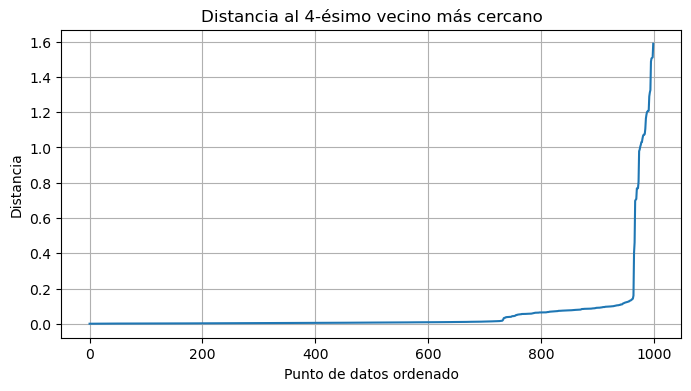

In [63]:
from sklearn.neighbors import NearestNeighbors

# Elegir k = min_samples (por ejemplo 2, 3, 4, etc.)
k = 4  # puedes probar con otros valores también
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(features_scaled)
distances, indices = neighbors_fit.kneighbors(features_scaled)

# Ordenar las distancias al k-ésimo vecino más cercano
k_distances = np.sort(distances[:, k-1])  # columna k-1 = distancia al k-ésimo vecino

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title("Distancia al {}-ésimo vecino más cercano".format(k))
plt.xlabel("Punto de datos ordenado")
plt.ylabel("Distancia")
plt.grid(True)
plt.show()

In [62]:
dff.describe()

statistic,walks_on_n_legs,height,weight,has_wings,has_tail,label
str,f64,f64,f64,f64,f64,f64
"""count""",1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.995,1.492775,1146.052381,0.258,0.985,1.394
"""std""",1.024707,1.337228,2046.772823,0.437753,0.121613,1.187508
"""min""",1.0,0.136315,0.075579,0.0,0.0,-1.0
"""25%""",2.0,0.384633,6.241849,0.0,1.0,0.0
"""50%""",3.0,1.617079,57.774582,0.0,1.0,1.0
"""75%""",4.0,2.513869,727.215039,1.0,1.0,2.0
"""max""",5.0,9.83936,6897.044478,1.0,1.0,3.0
